# 06__process_mpranalyze_data_crossrep

in this notebook, i process the results that come out of running MPRAnalyze on each of the models, call significantly differentially active sequences, and merge results into one master dataframe. (this is only for the cross replicate comparison)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from classify_utils import *

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
# mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

## variables

In [5]:
data_dir = "../../../data/02__mpra/02__activs"
alpha_f = "%s/alpha_per_elem.quantification.txt" % data_dir
human_vals_f = "%s/human_TSS_vals.both_tiles.txt" % data_dir
mouse_vals_f= "%s/mouse_TSS_vals.both_tiles.txt" % data_dir

In [6]:
HUES64_cis_f = "%s/HUES64_cis_results.REP1_ONLY.txt" % data_dir
mESC_cis_f = "%s/mESC_cis_results.REP1_ONLY.txt" % data_dir
human_trans_f = "%s/human_trans_results.REP2_ONLY.txt" % data_dir
mouse_trans_f = "%s/mouse_trans_results.REP2_ONLY.txt" % data_dir

In [7]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.RECLASSIFIED_WITH_MAX.txt"

## 1. import data

In [8]:
alpha = pd.read_table(alpha_f, sep="\t").reset_index()
alpha.head()

,index,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj
0,AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...,7.295239,6.315911,2.825214e-75,1.383066e-42,4.596852e-74,1.878236e-41
1,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...,1.326796,1.348824,1.451021e-01,2.326515e-01,3.319934e-01,5.455262e-01
2,AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...,0.977164,1.548916,4.814953e-01,1.057092e-01,7.164347e-01,3.127558e-01
3,AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...,0.976127,0.818171,4.826910e-01,7.414048e-01,7.167637e-01,8.145300e-01
4,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...,1.323999,1.457128,1.469545e-01,1.559242e-01,3.356231e-01,4.172106e-01


In [9]:
len(alpha)

13879

In [10]:
human_vals = pd.read_table(human_vals_f)
mouse_vals = pd.read_table(mouse_vals_f)
human_vals.head()

,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,element,tile_type,element_id,name,...,dupe_info,HUES64_log,mESC_log,tss_id,species,tss_tile_num,hg19_id,minimal_biotype_hg19,stem_exp_hg19,orig_species
0,1.326796,1.348824,0.145102,0.232651,0.331993,0.545526,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...,WILDTYPE,HUMAN_EVO_TSS__h.1133__tile1:129255098-1292552...,HUMAN_EVO_TSS__h.1133__tile1,...,7281.1.0.0,0.122804,0.129955,h.1133,HUMAN,tile1,h.1133,eRNA,0.20306,human
1,1.202075,1.503351,0.242922,0.128950,0.488166,0.364500,CTACTCCGGAGGCTGAGGCAGGAGAATCGCTTGAACCCGGGGGTGG...,WILDTYPE,HUMAN_EVO_TSS__h.1133__tile2:129255212-1292553...,HUMAN_EVO_TSS__h.1133__tile2,...,7282.1.0.0,0.079932,0.177061,h.1133,HUMAN,tile2,h.1133,eRNA,0.20306,human
2,1.323999,1.457128,0.146955,0.155924,0.335623,0.417211,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...,WILDTYPE,HUMAN_EVO_TSS__h.1436__tile1:157192113-1571922...,HUMAN_EVO_TSS__h.1436__tile1,...,4134.1.0.0,0.121888,0.163498,h.1436,HUMAN,tile1,h.1436,eRNA,0.039043800000000004,human
3,0.899162,0.755892,0.571115,0.790854,0.763290,0.837563,TTAAACTCGTTTAAACCAATTTTGAATAAGCTACTTCTTAGGCTAG...,WILDTYPE,HUMAN_EVO_TSS__h.1436__tile2:157191999-1571921...,HUMAN_EVO_TSS__h.1436__tile2,...,4133.1.0.0,-0.046162,-0.121540,h.1436,HUMAN,tile2,h.1436,eRNA,0.039043800000000004,human
4,1.137333,1.305637,0.305141,0.268285,0.564281,0.591663,AAAAAAAAGAAGAAGTGGGGCTTTCCAGAGGTGATTAAGTCATGAG...,WILDTYPE,HUMAN_EVO_TSS__h.1951__tile1:208526987-2085271...,HUMAN_EVO_TSS__h.1951__tile1,...,4272.1.0.0,0.055888,0.115822,h.1951,HUMAN,tile1,h.1951,lncRNA,0.028888900000000002,human


In [11]:
HUES64_cis = pd.read_table(HUES64_cis_f).reset_index()
HUES64_cis.columns = ["index", "stat_cis_HUES64", "pval_cis_HUES64", "fdr_cis_HUES64", "df.test_cis_HUES64", 
                      "df.dna_cis_HUES64", "df.rna.full_cis_HUES64", "df.rna.red_cis_HUES64", "logFC_cis_HUES64"]
HUES64_cis["index"] = HUES64_cis.apply(fix_ctrl_id, axis=1)

mESC_cis = pd.read_table(mESC_cis_f).reset_index()
mESC_cis.columns = ["index", "stat_cis_mESC", "pval_cis_mESC", "fdr_cis_mESC", "df.test_cis_mESC", 
                    "df.dna_cis_mESC", "df.rna.full_cis_mESC", "df.rna.red_cis_mESC", "logFC_cis_mESC"]
mESC_cis["index"] = mESC_cis.apply(fix_ctrl_id, axis=1)

In [12]:
human_trans = pd.read_table(human_trans_f).reset_index()
human_trans.columns = ["index", "stat_trans_human", "pval_trans_human", "fdr_trans_human", "df.test_trans_human", 
                       "df.dna_trans_human", "df.rna.full_trans_human", "df.rna.red_trans_human", "logFC_trans_human"]
human_trans["index"] = human_trans.apply(fix_ctrl_id, axis=1)

mouse_trans = pd.read_table(mouse_trans_f).reset_index()
mouse_trans.columns = ["index", "stat_trans_mouse", "pval_trans_mouse", "fdr_trans_mouse", "df.test_trans_mouse", 
                       "df.dna_trans_mouse", "df.rna.full_trans_mouse", "df.rna.red_trans_mouse", "logFC_trans_mouse"]
mouse_trans["index"] = mouse_trans.apply(fix_ctrl_id, axis=1)

In [13]:
tss_map = pd.read_table(tss_map_f)
tss_map.head()

,hg19_id,mm9_id,cage_id_hg19,cage_id_mm9,name_peak_hg19,name_peak_mm9,biotype_hg19,biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9,...,stem_exp_mm9,max_cage_hg19,max_cage_mm9,orig_species,har,tss_tile_num_max_hg19,tss_tile_num_max_mm9,n_tiles_hg19,n_tiles_mm9,tile_match
0,h.0,m.0,"chr1:2984976..2984989,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,0.0175,367.0,2286.0,human,False,NaN,NaN,NaN,NaN,NaN
1,h.1,m.0,"chr1:2984997..2985037,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,0.0175,367.0,2286.0,human,False,NaN,NaN,NaN,NaN,NaN
2,h.2,m.1,"chr1:2985420..2985438,-","chr4:154011250..154011257,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,0.0,6966.0,1361.0,human,False,tile1,tile1,2.0,2.0,tile1:tile1
3,h.3,m.2,"chr1:8086546..8086571,+","chr4:150229039..150229050,-",ENSG00000238290.1,ENSMUSG00000078492.3,divergent,antisense,lncRNA,lncRNA,...,0.0,960.0,123.0,human,False,tile1,tile1,1.0,1.0,tile1:tile1
4,h.4,m.3,"chr1:26498321..26498327,-","chr4:133799669..133799683,+",ENSG00000236782.1,ENSMUSG00000086322.7,antisense,protein_coding,other,mRNA,...,0.0,753.0,770.0,human,False,tile1,tile1,2.0,2.0,tile1:tile1


In [14]:
tss_map.minimal_biotype_hg19.value_counts()

lncRNA              1142
mRNA                1089
eRNA                 701
other                486
no CAGE activity     371
Name: minimal_biotype_hg19, dtype: int64

## 2. add biotype switch to TSS map

In [15]:
tss_map[tss_map["hg19_id"] == "h.14"]

,hg19_id,mm9_id,cage_id_hg19,cage_id_mm9,name_peak_hg19,name_peak_mm9,biotype_hg19,biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9,...,stem_exp_mm9,max_cage_hg19,max_cage_mm9,orig_species,har,tss_tile_num_max_hg19,tss_tile_num_max_mm9,n_tiles_hg19,n_tiles_mm9,tile_match
14,h.14,m.10,"chr1:145096480..145096513,+","chr3:97705122..97705173,+",ENSG00000223380.3,ENSMUSG00000027879.9,intergenic,protein_coding,mRNA,mRNA,...,25.7075,53131.0,44332.0,human,False,tile2,tile1,1.0,4.0,tile1:tile2


In [16]:
tss_map.minimal_biotype_hg19.value_counts()

lncRNA              1142
mRNA                1089
eRNA                 701
other                486
no CAGE activity     371
Name: minimal_biotype_hg19, dtype: int64

In [17]:
len(tss_map)

3789

In [18]:
tss_map["biotype_switch_minimal"] = tss_map.apply(biotype_switch_minimal, axis=1)
tss_map.biotype_switch_minimal.value_counts()

mRNA                      1006
lncRNA                     657
eRNA                       501
biotype switch             432
CAGE turnover - lncRNA     384
CAGE turnover - eRNA       327
other                      289
CAGE turnover - other      101
CAGE turnover - mRNA        92
Name: biotype_switch_minimal, dtype: int64

## 3. merge alphas with TSS map

split up into tile1 and tile2

In [19]:
human_vals_sub = human_vals[["element", "tss_id", "tss_tile_num"]]
human_vals_sub.columns = ["hg19_element", "hg19_id", "hg19_tile_num"]

mouse_vals_sub = mouse_vals[["element", "tss_id", "tss_tile_num"]]
mouse_vals_sub.columns = ["mm9_element", "mm9_id", "mm9_tile_num"]
mouse_vals_sub.sample(5)

,mm9_element,mm9_id,mm9_tile_num
1890,TAGTCAGCAGAATAGTACTGAGCACGGTATTTCCCCCCCTTTGCTG...,m.1446,tile1
1210,ACTCTGAGGCAGATTATACTACTGCTTAGAGAATGGTGAAGAGGGG...,m.1202,tile2
5077,GCCAAAACCTCATCCTCCGATTCAACAAAACCGATCCCCAGAAGAT...,m.58,tile2
3609,GTCCAGGAGCTGCCAGTCCAGGATTGGTCCGTAACTCCCAAGTTCC...,m.741,tile1
5120,GCCCACTTCACCCAGACCCATTGGGATCACCTCCGACCGCTGGTTA...,m.1713,tile2


In [20]:
human_vals_tile1 = human_vals_sub[human_vals_sub["hg19_tile_num"] == "tile1"].drop_duplicates()
human_vals_tile2 = human_vals_sub[human_vals_sub["hg19_tile_num"] == "tile2"].drop_duplicates()
mouse_vals_tile1 = mouse_vals_sub[mouse_vals_sub["mm9_tile_num"] == "tile1"].drop_duplicates()
mouse_vals_tile2 = mouse_vals_sub[mouse_vals_sub["mm9_tile_num"] == "tile2"].drop_duplicates()

print(len(human_vals_tile1))
print(len(human_vals_tile2))
print(len(mouse_vals_tile1))
print(len(mouse_vals_tile2))

2943
3021
2917
2980


In [21]:
# both_tile_ids = tss_map[(tss_map["n_tiles_hg19"] >= 2) & (tss_map["n_tiles_mm9"] >= 2)]
both_tile_ids = tss_map[(~pd.isnull(tss_map["n_tiles_hg19"]) & ~(pd.isnull(tss_map["n_tiles_mm9"])))]
len(both_tile_ids)

3312

In [22]:
tile1_ids = both_tile_ids[(both_tile_ids["tile_match"] == "tile1:tile1") | 
                          (both_tile_ids["tile_match"] == "tile1:tile2")][["hg19_id", "mm9_id"]].drop_duplicates()
len(tile1_ids)

2693

In [23]:
tile2_ids = both_tile_ids[(both_tile_ids["tile_match"] == "tile2:tile2")][["hg19_id", "mm9_id"]].drop_duplicates()
len(tile2_ids)

598

In [24]:
tss_map_tile1 = tile1_ids.merge(tss_map, on=["hg19_id", "mm9_id"], how="left")
tss_map_tile1 = tss_map_tile1.merge(human_vals_tile1, on="hg19_id").merge(mouse_vals_tile1, on="mm9_id")
print(len(tss_map_tile1))

2352


In [25]:
tss_map_tile2 = tile2_ids.merge(tss_map, on=["hg19_id", "mm9_id"], how="left")
tss_map_tile2 = tss_map_tile2.merge(human_vals_tile2, on="hg19_id").merge(mouse_vals_tile2, on="mm9_id")
print(len(tss_map_tile2))

600


In [26]:
tss_map_tile1 = tss_map_tile1.merge(alpha, 
                                    left_on="hg19_element", 
                                    right_on="index").merge(alpha,
                                                            left_on="mm9_element",
                                                            right_on="index",
                                                            suffixes=("_hg19", "_mm9"))
tss_map_tile1["tss_tile_num"] = "tile1"
tss_map_tile1.head()

,hg19_id,mm9_id,cage_id_hg19,cage_id_mm9,name_peak_hg19,name_peak_mm9,biotype_hg19,biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9,...,HUES64_padj_hg19,mESC_padj_hg19,index_mm9,HUES64_mm9,mESC_mm9,HUES64_pval_mm9,mESC_pval_mm9,HUES64_padj_mm9,mESC_padj_mm9,tss_tile_num
0,h.2,m.1,"chr1:2985420..2985438,-","chr4:154011250..154011257,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,1.812116e-03,6.958630e-01,CCCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCT...,1.929367,1.179409,2.550782e-03,0.385808,8.819708e-03,0.692688,tile1
1,h.3,m.2,"chr1:8086546..8086571,+","chr4:150229039..150229050,-",ENSG00000238290.1,ENSMUSG00000078492.3,divergent,antisense,lncRNA,lncRNA,...,4.883017e-01,6.945105e-01,TATTTATACGGTGAGCGACAACGTGACGTCAACGCCCGCAGCCCCG...,1.312270,1.914743,1.548958e-01,0.013920,3.497883e-01,0.055405,tile1
2,h.4,m.3,"chr1:26498321..26498327,-","chr4:133799669..133799683,+",ENSG00000236782.1,ENSMUSG00000086322.7,antisense,protein_coding,other,mRNA,...,2.428031e-01,4.505074e-01,GATATTCAGGCCTGATGCTGATCCCTCCTGACAGCTGCTCCTAAGG...,1.653914,1.499628,2.254412e-02,0.130995,6.724474e-02,0.368915,tile1
3,h.5,m.4,"chr1:65533390..65533443,-","chr4:101029310..101029334,-",ENSG00000231485.1,ENSMUSG00000086782.2,intergenic,intergenic,lncRNA,other,...,1.368040e-14,1.753169e-23,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,3.223137,2.285388,3.022069e-11,0.000784,1.727483e-10,0.003826,tile1
4,h.6,m.4,"chr1:65533457..65533465,-","chr4:101029310..101029334,-",ENSG00000231485.1,ENSMUSG00000086782.2,intergenic,intergenic,lncRNA,other,...,3.003835e-10,2.655447e-09,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,3.223137,2.285388,3.022069e-11,0.000784,1.727483e-10,0.003826,tile1


In [27]:
tss_map_tile2 = tss_map_tile2.merge(alpha, 
                                    left_on="hg19_element", 
                                    right_on="index").merge(alpha,
                                                            left_on="mm9_element",
                                                            right_on="index",
                                                            suffixes=("_hg19", "_mm9"))
tss_map_tile2["tss_tile_num"] = "tile2"
tss_map_tile2.head()

,hg19_id,mm9_id,cage_id_hg19,cage_id_mm9,name_peak_hg19,name_peak_mm9,biotype_hg19,biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9,...,HUES64_padj_hg19,mESC_padj_hg19,index_mm9,HUES64_mm9,mESC_mm9,HUES64_pval_mm9,mESC_pval_mm9,HUES64_padj_mm9,mESC_padj_mm9,tss_tile_num
0,h.15,m.11,"chr1:151763294..151763320,+","chr3:94216809..94216812,-",ENSG00000203288.3,ENSMUSG00000097515.2,divergent,divergent,lncRNA,lncRNA,...,5.137919e-06,1.235504e-02,CCCGGATGAAAATCCAAGCCCGCCCACGTCCACAGCCAGTTAGAGC...,0.994039,1.569460,4.620743e-01,9.628427e-02,7.051269e-01,2.917750e-01,tile2
1,h.16,m.11,"chr1:151763321..151763339,+","chr3:94216809..94216812,-",ENSG00000203288.3,ENSMUSG00000097515.2,divergent,divergent,lncRNA,lncRNA,...,3.968783e-29,1.654646e-08,CCCGGATGAAAATCCAAGCCCGCCCACGTCCACAGCCAGTTAGAGC...,0.994039,1.569460,4.620743e-01,9.628427e-02,7.051269e-01,2.917750e-01,tile2
2,h.19,m.14,"chr1:179851611..179851688,-","chr1:157883318..157883388,+",ENSG00000272906.1,ENSMUSG00000050565.16,divergent,protein_coding,lncRNA,mRNA,...,3.053028e-194,1.646213e-102,TTTGGCCGCCCGGGGCTCGAAGTCGCCGTACACTTCTGCCGGCTCC...,11.784031,6.543975,2.049327e-215,3.482717e-46,9.740620e-214,4.917256e-45,tile2
3,h.25,m.20,"chr1:208042503..208042527,-","chr1:196802536..196802585,+",ENSG00000203709.5,ENSMUSG00000096929.7,intergenic,intergenic,other,other,...,8.534530e-01,7.093100e-01,CAGAGGAACCAGGACCAGTGAGGATCTGGACAGCTCTGAAGAAGCA...,0.658347,0.878549,8.094159e-01,6.882557e-01,8.572866e-01,7.922095e-01,tile2
4,h.27,m.22,"chr1:209602671..209602695,+","chr1:195336318..195336327,-",ENSG00000230937.5,ENSMUSG00000097850.2,intergenic,intergenic,other,other,...,3.645676e-01,7.892178e-01,CCTCTGCAAGCACGTCCCACCCCCAGAGGTGTGGTTCTTGGAGGCG...,4.684714,3.533410,2.382336e-27,7.649995e-11,2.028493e-26,5.623638e-10,tile2


In [28]:
tss_map = tss_map_tile1.append(tss_map_tile2)
tss_map.biotype_hg19.value_counts()

no cage activity    747
protein_coding      645
enhancer            567
intergenic          436
divergent           264
antisense           236
unassigned           54
multi-mapped          3
Name: biotype_hg19, dtype: int64

In [29]:
data = tss_map[["hg19_id", "chr_tss_hg19", "start_tss_hg19", "biotype_hg19", 
                "minimal_biotype_hg19", "cage_id_hg19", "name_peak_hg19", "stem_exp_hg19", "max_cage_hg19", 
                "mm9_id", "chr_tss_mm9", 
                "start_tss_mm9", "biotype_mm9", "minimal_biotype_mm9", "cage_id_mm9", 
                "name_peak_mm9", "stem_exp_mm9", "max_cage_mm9", "tss_tile_num", "orig_species", 
                "biotype_switch_minimal", "HUES64_hg19", "mESC_hg19", "HUES64_mm9", "mESC_mm9", "HUES64_padj_hg19", 
                "mESC_padj_hg19", "HUES64_padj_mm9", "mESC_padj_mm9"]].drop_duplicates()
data.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,minimal_biotype_hg19,cage_id_hg19,name_peak_hg19,stem_exp_hg19,max_cage_hg19,mm9_id,...,orig_species,biotype_switch_minimal,HUES64_hg19,mESC_hg19,HUES64_mm9,mESC_mm9,HUES64_padj_hg19,mESC_padj_hg19,HUES64_padj_mm9,mESC_padj_mm9
1989,h.3078,chr3,97542107,no cage activity,no CAGE activity,no cage activity,no cage activity,no cage activity,7.0,m.2889,...,mouse,CAGE turnover - other,1.047303,0.787523,1.100521,1.108319,6.567565e-01,0.826043,6.041642e-01,7.275843e-01
1683,h.3649,chr9,16726903,antisense,lncRNA,"chr9:16726892..16726913,+",ENSG00000234779.1,2.45333,NaN,m.3479,...,human,biotype switch,1.408525,1.407051,0.732473,0.946109,2.428031e-01,0.477197,8.267583e-01,7.740556e-01
904,h.1388,chr9,96929124,enhancer,eRNA,chr9:96928795-96929410,chr9:96928795-96929410__POSITIVE,2.81033,224.0,m.1246,...,human,eRNA,12.706167,16.919308,9.248919,9.499261,1.701529e-251,0.000000,6.918633e-126,3.722038e-105
89,h.633,chr19,46366404,protein_coding,mRNA,"chr19:46366392..46366430,-",ENSG00000125755.14,24.4944,52349.0,m.519,...,human,mRNA,29.113708,29.290985,6.116300,6.201800,0.000000e+00,0.000000,1.733697e-49,1.021344e-39
397,h.2477,chrX,107313304,enhancer,eRNA,chrX:107313303-107313469,chrX:107313303-107313469__NEGATIVE,0.0285395,4.0,m.2289,...,human,CAGE turnover - eRNA,1.072119,1.042659,1.219942,1.167671,6.321763e-01,0.754168,4.653931e-01,6.995800e-01


In [30]:
len(data)

2952

## 4. find appropriate FDR cutoffs for each model
choose FDR cutoff as the one that calls < 10% of controls as significant

In [31]:
cis_HUES64_ctrls = HUES64_cis[HUES64_cis["index"].str.contains("CONTROL")]
cis_mESC_ctrls = mESC_cis[mESC_cis["index"].str.contains("CONTROL")]
trans_human_ctrls = human_trans[human_trans["index"].str.contains("CONTROL")]
trans_mouse_ctrls = mouse_trans[mouse_trans["index"].str.contains("CONTROL")]

In [32]:
print(len(cis_HUES64_ctrls))
print(len(cis_mESC_ctrls))
print(len(trans_human_ctrls))
print(len(trans_mouse_ctrls))

400
400
400
400


make plots to show different #s of controls called as "significant" at alpha < 0.05 in each model

In [33]:
n_sig_models = {}
for model, df, fdr in zip(["HUES64 cis effects", "mESC cis effects", "human trans effects",
                           "mouse trans effects"],
                          [cis_HUES64_ctrls, cis_mESC_ctrls, trans_human_ctrls, trans_mouse_ctrls],
                          ["fdr_cis_HUES64", "fdr_cis_mESC", "fdr_trans_human", "fdr_trans_mouse"]):
    n_sig = len(df[df[fdr] < 0.05])
    n_sig_models[model] = [n_sig]
n_sig_models = pd.DataFrame.from_dict(n_sig_models, orient="index").reset_index()
n_sig_models.columns = ["model", "n_sig"]
n_sig_models

,model,n_sig
0,HUES64 cis effects,33
1,mESC cis effects,31
2,human trans effects,1
3,mouse trans effects,1


In [34]:
order = ["native effects", "HUES64 cis effects", "mESC cis effects", "human trans effects", "mouse trans effects"]

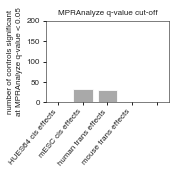

In [35]:
fig, ax = plt.subplots(figsize=(2.2, 1.5), nrows=1, ncols=1)

sns.barplot(data=n_sig_models, x="model", y="n_sig", color="darkgray", ax=ax, order=order)
ax.set_xlabel("")
ax.set_ylabel("number of controls significant\nat MPRAnalyze q-value < 0.05")
_ = ax.set_xticklabels(n_sig_models["model"], rotation=50, ha="right", va="top")

ax.set_title("MPRAnalyze q-value cut-off")
ax.set_ylim((0, 200))
fig.savefig("FigS6B.pdf", dpi="figure", bbox_inches="tight")

now always cut off at the 10th percentile of FDRs of controls within a given model

In [41]:
NATIVE_THRESH = np.percentile(native_ctrls["fdr_native"], 5)
NATIVE_THRESH

1.0898206312680145e-06

In [42]:
CIS_HUES64_THRESH = np.percentile(cis_HUES64_ctrls["fdr_cis_HUES64"], 5)
CIS_HUES64_THRESH

1.8999985664019451e-05

In [43]:
CIS_MESC_THRESH = np.percentile(cis_mESC_ctrls["fdr_cis_mESC"], 5)
CIS_MESC_THRESH

0.00014680699049394292

In [44]:
TRANS_HUMAN_THRESH = np.percentile(trans_human_ctrls["fdr_trans_human"], 5)
TRANS_HUMAN_THRESH

0.0043537916079706166

In [45]:
TRANS_MOUSE_THRESH = np.percentile(trans_mouse_ctrls["fdr_trans_mouse"], 5)
TRANS_MOUSE_THRESH

0.0021730207540922755

In [46]:
INT_THRESH = np.percentile(cis_trans_int_ctrls["fdr_int"], 5)
INT_THRESH

0.83542370624282325

now re-plot with threshold

In [47]:
n_sig_models = {}
for model, df, fdr, thresh in zip(["native effects", "HUES64 cis effects", "mESC cis effects", "human trans effects",
                                   "mouse trans effects", "cis/trans interaction effects"],
                                  [native_ctrls, cis_HUES64_ctrls, cis_mESC_ctrls, trans_human_ctrls, 
                                   trans_mouse_ctrls, cis_trans_int_ctrls],
                                  ["fdr_native", "fdr_cis_HUES64", "fdr_cis_mESC", "fdr_trans_human", 
                                   "fdr_trans_mouse", "fdr_int"],
                                  [NATIVE_THRESH, CIS_HUES64_THRESH, CIS_MESC_THRESH, TRANS_HUMAN_THRESH,
                                   TRANS_MOUSE_THRESH, 0.05]):
    n_sig = len(df[df[fdr] < thresh])
    n_sig_models[model] = [n_sig]
n_sig_models = pd.DataFrame.from_dict(n_sig_models, orient="index").reset_index()
n_sig_models.columns = ["model", "n_sig"]
n_sig_models

,model,n_sig
0,native effects,20
1,HUES64 cis effects,20
2,mESC cis effects,20
3,human trans effects,20
4,mouse trans effects,20
5,cis/trans interaction effects,0


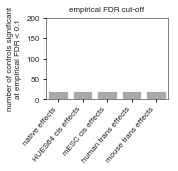

In [48]:
fig, ax = plt.subplots(figsize=(2.2, 1.5), nrows=1, ncols=1)

sns.barplot(data=n_sig_models, x="model", y="n_sig", color="darkgray", ax=ax, order=order)
ax.set_xlabel("")
ax.set_ylabel("number of controls significant\nat empirical FDR < 0.1")
_ = ax.set_xticklabels(n_sig_models["model"], rotation=50, ha="right", va="top")

ax.set_title("empirical FDR cut-off")
ax.set_ylim((0, 200))
fig.savefig("FigS6C.pdf", dpi="figure", bbox_inches="tight")

## 5. plot controls vs. TSSs for each model

control boxplots

In [49]:
order = ["control", "TSS"]
pal = {"control": "gray", "TSS": "black"}

models = ["native", "HUES64 cis", "mESC cis", "human trans", "mouse trans", "cis/trans interaction"]
dfs = [native, HUES64_cis, mESC_cis, human_trans, mouse_trans, cis_trans_int]
logFCs = ["logFC_native", "logFC_cis_HUES64", "logFC_cis_mESC", "logFC_trans_human", "logFC_trans_mouse", "logFC_int"]
labels = ["native", "cis_HUES64", "cis_mESC", "trans_human", "trans_mouse", "cis_trans_int"]

volcano plots

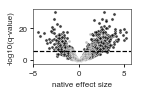

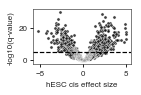

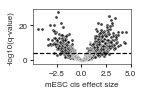

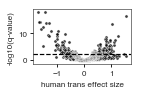

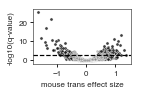

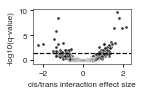

In [50]:
threshs = [NATIVE_THRESH, CIS_HUES64_THRESH, CIS_MESC_THRESH, TRANS_HUMAN_THRESH, TRANS_MOUSE_THRESH, 0.05]
fdrs = ["fdr_native", "fdr_cis_HUES64", "fdr_cis_mESC", "fdr_trans_human", "fdr_trans_mouse", "fdr_int"]
saves = [True, True, True, True, True, False]
names = ["Fig6E.pdf", "Fig2B_1.pdf", "Fig2B_2.pdf", "Fig4B_1.pdf", "Fig4B_2.pdf", None]

for model, df, logFC, fdr, label, thresh, save, name in zip(models, dfs, logFCs, fdrs, labels, threshs, saves, names):
    df["is_ctrl"] = df.apply(is_ctrl, axis=1)
    
    neg_ctrls = df[df["is_ctrl"] == "control"]
    tss = df[df["is_ctrl"] != "control"]
    
    fig, ax = plt.subplots(figsize=(1.75, 1), nrows=1, ncols=1)

    ax.scatter(tss[logFC], -np.log10(tss[fdr]), s=10, alpha=0.75, 
               color="black", linewidths=0.5, edgecolors="white")
    ax.scatter(neg_ctrls[logFC], -np.log10(neg_ctrls[fdr]), s=8, alpha=0.5, 
               color="gray", linewidths=0.5, edgecolors="white")

    plt.xlabel("%s effect size" % model)
    if model == "HUES64 cis":
        plt.xlabel("hESC cis effect size")
    plt.ylabel("-log10(q-value)")
    ax.axhline(y=-np.log10(thresh), color="black", linestyle="dashed")

    plt.show()
    if save:
        fig.savefig(name, dpi="figure", bbox_inches="tight")
    plt.close()

## 6. split result file indeces

In [51]:
native["hg19_id"] = native["index"].str.split("__", expand=True)[0]
native["biotype_hg19"] = native["index"].str.split("__", expand=True)[1]
native["mm9_id"] = native["index"].str.split("__", expand=True)[2]
native["biotype_mm9"] = native["index"].str.split("__", expand=True)[3]
native["tss_tile_num"] = native["index"].str.split("__", expand=True)[4]

In [52]:
HUES64_cis["hg19_id"] = HUES64_cis["index"].str.split("__", expand=True)[0]
HUES64_cis["biotype_hg19"] = HUES64_cis["index"].str.split("__", expand=True)[1]
HUES64_cis["mm9_id"] = HUES64_cis["index"].str.split("__", expand=True)[2]
HUES64_cis["biotype_mm9"] = HUES64_cis["index"].str.split("__", expand=True)[3]
HUES64_cis["tss_tile_num"] = HUES64_cis["index"].str.split("__", expand=True)[4]

In [53]:
mESC_cis["hg19_id"] = mESC_cis["index"].str.split("__", expand=True)[0]
mESC_cis["biotype_hg19"] = mESC_cis["index"].str.split("__", expand=True)[1]
mESC_cis["mm9_id"] = mESC_cis["index"].str.split("__", expand=True)[2]
mESC_cis["biotype_mm9"] = mESC_cis["index"].str.split("__", expand=True)[3]
mESC_cis["tss_tile_num"] = mESC_cis["index"].str.split("__", expand=True)[4]

In [54]:
human_trans["hg19_id"] = human_trans["index"].str.split("__", expand=True)[0]
human_trans["biotype_hg19"] = human_trans["index"].str.split("__", expand=True)[1]
human_trans["mm9_id"] = human_trans["index"].str.split("__", expand=True)[2]
human_trans["biotype_mm9"] = human_trans["index"].str.split("__", expand=True)[3]
human_trans["tss_tile_num"] = human_trans["index"].str.split("__", expand=True)[4]

In [55]:
mouse_trans["hg19_id"] = mouse_trans["index"].str.split("__", expand=True)[0]
mouse_trans["biotype_hg19"] = mouse_trans["index"].str.split("__", expand=True)[1]
mouse_trans["mm9_id"] = mouse_trans["index"].str.split("__", expand=True)[2]
mouse_trans["biotype_mm9"] = mouse_trans["index"].str.split("__", expand=True)[3]
mouse_trans["tss_tile_num"] = mouse_trans["index"].str.split("__", expand=True)[4]

In [56]:
cis_trans_int["hg19_id"] = cis_trans_int["index"].str.split("__", expand=True)[0]
cis_trans_int["biotype_hg19"] = cis_trans_int["index"].str.split("__", expand=True)[1]
cis_trans_int["mm9_id"] = cis_trans_int["index"].str.split("__", expand=True)[2]
cis_trans_int["biotype_mm9"] = cis_trans_int["index"].str.split("__", expand=True)[3]
cis_trans_int["tss_tile_num"] = cis_trans_int["index"].str.split("__", expand=True)[4]

## 7. merge result files w/ activity data

In [57]:
len(data)

2952

In [58]:
tmp = data.merge(native[["hg19_id", "mm9_id", "tss_tile_num", "logFC_native", "fdr_native"]], 
                 on=["hg19_id", "mm9_id", "tss_tile_num"], how="right")
len(tmp)

3352

In [59]:
tmp = tmp.merge(HUES64_cis[["hg19_id", "mm9_id", "tss_tile_num", "logFC_cis_HUES64", "fdr_cis_HUES64"]], 
                on=["hg19_id", "mm9_id", "tss_tile_num"], how="right")
len(tmp)

3352

In [60]:
tmp = tmp.merge(mESC_cis[["hg19_id", "mm9_id", "tss_tile_num", "logFC_cis_mESC", "fdr_cis_mESC"]], 
                on=["hg19_id", "mm9_id", "tss_tile_num"], how="right")
len(tmp)

3352

In [61]:
tmp = tmp.merge(human_trans[["hg19_id", "mm9_id", "tss_tile_num", "logFC_trans_human", "fdr_trans_human"]], 
                on=["hg19_id", "mm9_id", "tss_tile_num"], how="right")
len(tmp)

3352

In [62]:
tmp = tmp.merge(mouse_trans[["hg19_id", "mm9_id", "tss_tile_num", "logFC_trans_mouse", "fdr_trans_mouse"]], 
                on=["hg19_id", "mm9_id", "tss_tile_num"], how="right")
len(tmp)

3352

In [63]:
tmp = tmp.merge(cis_trans_int[["hg19_id", "mm9_id", "tss_tile_num", "logFC_int", "fdr_int"]], 
                on=["hg19_id", "mm9_id", "tss_tile_num"], how="right")
print(len(tmp))
tmp.sample(5)

3352


,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,minimal_biotype_hg19,cage_id_hg19,name_peak_hg19,stem_exp_hg19,max_cage_hg19,mm9_id,...,logFC_cis_HUES64,fdr_cis_HUES64,logFC_cis_mESC,fdr_cis_mESC,logFC_trans_human,fdr_trans_human,logFC_trans_mouse,fdr_trans_mouse,logFC_int,fdr_int
2942,h.3568,chr4,151102841.0,no cage activity,no CAGE activity,no cage activity,no cage activity,no cage activity,1.0,m.3378,...,1.724931,2.010247e-09,1.776946,7.576245e-10,0.579945,0.060932,0.640718,0.000094,0.099626,0.991115
1570,h.2511,chr16,53124972.0,enhancer,eRNA,chr16:53124874-53125001,chr16:53124874-53125001__POSITIVE,0.0287066,177.0,m.2323,...,-0.723110,1.781123e-02,-0.218478,5.215866e-01,-0.401297,0.082221,0.139765,0.609758,0.585777,0.482010
2858,h.3092,chr17,47964814.0,no cage activity,no CAGE activity,no cage activity,no cage activity,no cage activity,5.0,m.2903,...,-0.876929,8.523096e-05,-0.997746,1.237634e-05,0.344922,0.087566,0.161653,0.578726,-0.066833,0.991115
999,h.1550,chr12,76425020.0,antisense,other,"chr12:76425003..76425035,+",ENSG00000257453.1,0.154444,755.0,m.1362,...,-0.456065,5.831487e-02,-0.252783,2.977530e-01,0.026434,0.894621,0.140834,0.610544,0.168460,0.963892
1820,h.2786,chr18,3448180.0,no cage activity,lncRNA,no cage activity,no cage activity,no cage activity,274.0,m.2597,...,0.314288,3.774923e-01,0.526971,1.553810e-01,-0.265220,0.409422,-0.159394,0.577851,0.120291,0.991115


In [64]:
data = tmp.copy()

In [65]:
data.columns

Index(['hg19_id', 'chr_tss_hg19', 'start_tss_hg19', 'biotype_hg19',
       'minimal_biotype_hg19', 'cage_id_hg19', 'name_peak_hg19',
       'stem_exp_hg19', 'max_cage_hg19', 'mm9_id', 'chr_tss_mm9',
       'start_tss_mm9', 'biotype_mm9', 'minimal_biotype_mm9', 'cage_id_mm9',
       'name_peak_mm9', 'stem_exp_mm9', 'max_cage_mm9', 'tss_tile_num',
       'orig_species', 'biotype_switch_minimal', 'HUES64_hg19', 'mESC_hg19',
       'HUES64_mm9', 'mESC_mm9', 'HUES64_padj_hg19', 'mESC_padj_hg19',
       'HUES64_padj_mm9', 'mESC_padj_mm9', 'logFC_native', 'fdr_native',
       'logFC_cis_HUES64', 'fdr_cis_HUES64', 'logFC_cis_mESC', 'fdr_cis_mESC',
       'logFC_trans_human', 'fdr_trans_human', 'logFC_trans_mouse',
       'fdr_trans_mouse', 'logFC_int', 'fdr_int'],
      dtype='object')

## 8. classify comparison effects as sig vs. not sig

In [66]:
data["native_status"] = data.apply(comp_status, fdr_col="fdr_native", thresh=NATIVE_THRESH, txt="native", axis=1)
data["cis_HUES64_status"] = data.apply(comp_status, fdr_col="fdr_cis_HUES64", thresh=CIS_HUES64_THRESH, 
                                       txt="cis", axis=1)
data["cis_mESC_status"] = data.apply(comp_status, fdr_col="fdr_cis_mESC", thresh=CIS_MESC_THRESH, txt="cis", axis=1)
data["trans_human_status"] = data.apply(comp_status, fdr_col="fdr_trans_human", thresh=TRANS_HUMAN_THRESH,
                                        txt="trans", axis=1)
data["trans_mouse_status"] = data.apply(comp_status, fdr_col="fdr_trans_mouse", thresh=TRANS_MOUSE_THRESH,
                                        txt="trans", axis=1)
data["cis_trans_int_status"] = data.apply(comp_status, fdr_col="fdr_int", thresh=0.05, txt="cis/trans int.", axis=1)

In [67]:
data.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,minimal_biotype_hg19,cage_id_hg19,name_peak_hg19,stem_exp_hg19,max_cage_hg19,mm9_id,...,logFC_trans_mouse,fdr_trans_mouse,logFC_int,fdr_int,native_status,cis_HUES64_status,cis_mESC_status,trans_human_status,trans_mouse_status,cis_trans_int_status
1873,h.2883,chr2,26100437.0,no cage activity,other,no cage activity,no cage activity,no cage activity,162.0,m.2694,...,-0.727366,0.000057,-0.443259,0.440107,significant native effect,no cis effect,significant cis effect,no trans effect,significant trans effect,no cis/trans int. effect
2644,h.1857,chr21,46221794.0,divergent,lncRNA,"chr21:46221779..46221809,+",ENSG00000236519.1,0.946667,1198.0,m.1669,...,-0.434697,0.035701,-0.964024,0.146544,significant native effect,significant cis effect,no cis effect,no trans effect,no trans effect,no cis/trans int. effect
2016,h.3121,chr1,22352413.0,no cage activity,lncRNA,no cage activity,no cage activity,no cage activity,39.0,m.2932,...,0.060077,0.808415,0.091591,0.991115,no native effect,no cis effect,no cis effect,no trans effect,no trans effect,no cis/trans int. effect
1581,h.2531,chr2,151719496.0,enhancer,eRNA,chr2:151719468-151719497,chr2:151719468-151719497__POSITIVE,0.039043800000000004,6.0,m.2343,...,0.377546,0.263144,-0.310770,0.900129,no native effect,no cis effect,no cis effect,no trans effect,no trans effect,no cis/trans int. effect
1312,h.2087,chr11,65266063.0,intergenic,lncRNA,"chr11:65266057..65266080,+",ENSG00000251562.3,0.028888900000000002,297.0,m.1899,...,-0.004035,0.983580,0.239466,0.905592,no native effect,no cis effect,no cis effect,no trans effect,no trans effect,no cis/trans int. effect


## 9. compare l2fcs for elements called significant for each biotype & re-classify

In [68]:
min_order = ["no CAGE activity", "eRNA", "lncRNA", "mRNA", "other"]
palette = sns.husl_palette(n_colors=len(min_order))

0.634655810316


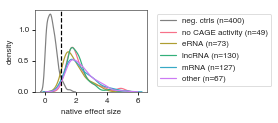

0.618433199293


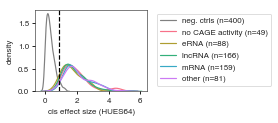

0.440755598097


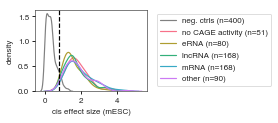

0.292565645359


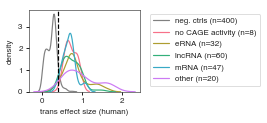

0.341798075047


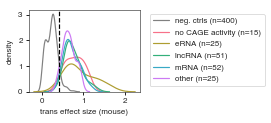

nan


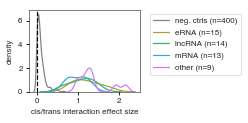

In [69]:
l2fc_cols = ["logFC_native", "logFC_cis_HUES64", "logFC_cis_mESC", "logFC_trans_human", "logFC_trans_mouse", 
             "logFC_int"]
sig_cols = ["native_status", "cis_HUES64_status", "cis_mESC_status", "trans_human_status", "trans_mouse_status",
            "cis_trans_int_status"]
xlabels = ["native effect size", "cis effect size (HUES64)", "cis effect size (mESC)", "trans effect size (human)",
           "trans effect size (mouse)", "cis/trans interaction effect size"]
xs = [1, 0.9, 0.8, 0.4, 0.4, 0]
min_vals = []

c = 1
for l2fc_col, sig_col, xlabel, x in zip(l2fc_cols, sig_cols, xlabels, xs):
    
    fig, ax = plt.subplots(figsize=(2, 1.5), nrows=1, ncols=1)
    filt = data[((data["HUES64_padj_hg19"] < QUANT_ALPHA) | (data["mESC_padj_mm9"] < QUANT_ALPHA))]
    ctrls = np.abs(data[data["hg19_id"].str.contains("ctrl.")][l2fc_col])
    
    sig_ctrls = data[(data["hg19_id"].str.contains("ctrl.")) & (data[sig_col].str.contains("significant"))][l2fc_col]
    min_val = np.min(np.abs(sig_ctrls))
    print(min_val)
    min_vals.append(min_val)
    
    sns.distplot(ctrls, hist=False, color="gray", label="neg. ctrls (n=%s)" % len(ctrls), ax=ax)
    
    sub = filt[~filt[sig_col].str.contains("no ")]
    for i, label in enumerate(min_order):
        
        vals = np.abs(sub[sub["minimal_biotype_hg19"] == label][l2fc_col])
        sns.distplot(vals, hist=False, color=palette[i], label="%s (n=%s)" % (label, len(vals)), ax=ax)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel("density")
    ax.axvline(x=x, linestyle="dashed", color="black")
    plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
    plt.show()
    fig.savefig("FigS7_%s.pdf" % c, dpi="figure", bbox_inches="tight")
    plt.close()
    c += 1

In [70]:
data.native_status.value_counts()

no native effect             2757
significant native effect     595
Name: native_status, dtype: int64

In [71]:
data["native_status"] = data.apply(comp_status_stringent, status_col="native_status", 
                                   l2fc_col="logFC_native", l2fc_thresh=min_vals[0], txt="native", axis=1)
data["cis_HUES64_status"] = data.apply(comp_status_stringent, status_col="cis_HUES64_status",  
                                       l2fc_col="logFC_cis_HUES64", l2fc_thresh=min_vals[1], txt="cis", axis=1)
data["cis_mESC_status"] = data.apply(comp_status_stringent, status_col="cis_mESC_status", 
                                     l2fc_col="logFC_cis_mESC", l2fc_thresh=min_vals[2], txt="cis", axis=1)
data["trans_human_status"] = data.apply(comp_status_stringent, status_col="trans_human_status", 
                                        l2fc_col="logFC_trans_human", l2fc_thresh=min_vals[3], txt="trans", axis=1)
data["trans_mouse_status"] = data.apply(comp_status_stringent, status_col="trans_mouse_status", 
                                        l2fc_col="logFC_trans_mouse", l2fc_thresh=min_vals[4], txt="trans", axis=1)
data["cis_trans_int_status"] = data.apply(comp_status_stringent, status_col="cis_trans_int_status", 
                                          l2fc_col="logFC_int", l2fc_thresh=0, txt="cis/trans int.", axis=1)

In [72]:
data.native_status.value_counts()

no native effect             2759
significant native effect     593
Name: native_status, dtype: int64

## 9. classify effects as higher in mouse or human

In [73]:
data["native_status_det"] = data.apply(comp_status_detail, status_col="native_status",
                                       logFC_col="logFC_native", txt="native", axis=1)
data["cis_HUES64_status_det"] = data.apply(comp_status_detail, status_col="cis_HUES64_status",
                                           logFC_col="logFC_cis_HUES64", txt="cis", axis=1)
data["cis_mESC_status_det"] = data.apply(comp_status_detail, status_col="cis_mESC_status",
                                         logFC_col="logFC_cis_mESC", txt="cis", axis=1)
data["trans_human_status_det"] = data.apply(comp_status_detail, status_col="trans_human_status",
                                            logFC_col="logFC_trans_human", txt="trans", axis=1)
data["trans_mouse_status_det"] = data.apply(comp_status_detail, status_col="trans_mouse_status",
                                            logFC_col="logFC_trans_mouse", txt="trans", axis=1)
data["cis_trans_int_status_det"] = data.apply(comp_status_detail, status_col="cis_trans_int_status", 
                                              logFC_col="logFC_int", txt="cis/trans int.", axis=1)

In [74]:
data.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,minimal_biotype_hg19,cage_id_hg19,name_peak_hg19,stem_exp_hg19,max_cage_hg19,mm9_id,...,cis_mESC_status,trans_human_status,trans_mouse_status,cis_trans_int_status,native_status_det,cis_HUES64_status_det,cis_mESC_status_det,trans_human_status_det,trans_mouse_status_det,cis_trans_int_status_det
862,h.1508,chr11,119562947.0,enhancer,eRNA,chr11:119562613-119562997,chr11:119562613-119562997__POSITIVE,0.0,12.0,m.1190,...,significant cis effect,no trans effect,significant trans effect,no cis/trans int. effect,native effect\n(higher in mouse),cis effect\n(higher in mouse),cis effect\n(higher in mouse),no trans effect,trans effect\n(higher in mouse),no cis/trans int. effect
1619,h.3606,chr11,124617024.0,unassigned,other,"chr11:124617020..124617061,+",unassigned,0.0422222,216.0,m.3415,...,no cis effect,no trans effect,significant trans effect,no cis/trans int. effect,no native effect,no cis effect,no cis effect,no trans effect,trans effect\n(higher in mouse),no cis/trans int. effect
89,h.151,chr17,37081824.0,intergenic,other,"chr17:37081817..37081833,+",ENSG00000263874.1,0.245556,2118.0,m.95,...,no cis effect,no trans effect,significant trans effect,no cis/trans int. effect,no native effect,cis effect\n(higher in mouse),no cis effect,no trans effect,trans effect\n(higher in human),no cis/trans int. effect
917,h.1415,chr6,32076157.0,enhancer,eRNA,chr6:32075999-32076179,chr6:32075999-32076179__POSITIVE,0.0,37.0,m.1262,...,no cis effect,no trans effect,no trans effect,no cis/trans int. effect,no native effect,no cis effect,no cis effect,no trans effect,no trans effect,no cis/trans int. effect
846,h.1304,chr11,19737103.0,enhancer,eRNA,chr11:19736892-19737150,chr11:19736892-19737150__NEGATIVE,0.0,23.0,m.1176,...,no cis effect,no trans effect,no trans effect,no cis/trans int. effect,no native effect,no cis effect,no cis effect,no trans effect,no trans effect,no cis/trans int. effect


## 10. classify cis & trans effects into one effect (since we measured in 2 contexts)

In [75]:
data["cis_status_one"] = data.apply(comp_status_one, status_col1="cis_HUES64_status", 
                                    status_col2="cis_mESC_status", txt="cis", axis=1)
data["trans_status_one"] = data.apply(comp_status_one, status_col1="trans_human_status", 
                                      status_col2="trans_mouse_status", txt="trans", axis=1)

In [76]:
data["cis_status_det_one"] = data.apply(comp_status_detail_one, status_col1="cis_HUES64_status", 
                                        status_col2="cis_mESC_status", logFC_col1="logFC_cis_HUES64", 
                                        logFC_col2="logFC_cis_mESC", txt="cis", axis=1)
data["trans_status_det_one"] = data.apply(comp_status_detail_one, status_col1="trans_human_status", 
                                          status_col2="trans_mouse_status", logFC_col1="logFC_trans_human", 
                                          logFC_col2="logFC_trans_mouse", txt="trans", axis=1)

In [77]:
data["logFC_cis_one"] = data.apply(comp_logFC_one, status_col1="cis_HUES64_status", status_col2="cis_mESC_status",
                                   logFC_col1="logFC_cis_HUES64", logFC_col2="logFC_cis_mESC", axis=1)
data["logFC_trans_one"] = data.apply(comp_logFC_one, status_col1="trans_human_status", status_col2="trans_mouse_status",
                                     logFC_col1="logFC_trans_human", logFC_col2="logFC_trans_mouse", axis=1)

## 11. print numbers with each effect

In [78]:
# remove ctrls
data = data[~data["hg19_id"].str.contains("ctrl")]
len(data)

2952

## native

In [79]:
data.native_status.value_counts()

no native effect             2378
significant native effect     574
Name: native_status, dtype: int64

## cis - HUES64

In [80]:
data.cis_HUES64_status.value_counts()

no cis effect             2207
significant cis effect     745
Name: cis_HUES64_status, dtype: int64

## cis - mESC

In [81]:
data.cis_mESC_status.value_counts()

no cis effect             2227
significant cis effect     725
Name: cis_mESC_status, dtype: int64

## trans - human

In [82]:
data.trans_human_status.value_counts()

no trans effect             2745
significant trans effect     207
Name: trans_human_status, dtype: int64

## trans - mouse

In [83]:
data.trans_mouse_status.value_counts()

no trans effect             2755
significant trans effect     197
Name: trans_mouse_status, dtype: int64

## cis/trans interactions

In [84]:
data.cis_trans_int_status.value_counts()

no cis/trans int. effect             2887
significant cis/trans int. effect      65
Name: cis_trans_int_status, dtype: int64

In [85]:
np.max(np.abs(data[data["trans_mouse_status"].str.contains("significant")]["fdr_trans_mouse"]))

0.00217233026378945

## 12. write files

In [86]:
# rearrange columns for readability
data = data[['hg19_id', 'chr_tss_hg19', 'start_tss_hg19', 'biotype_hg19', 'cage_id_hg19', 'name_peak_hg19', 
             'minimal_biotype_hg19', 'stem_exp_hg19', 'mm9_id', 'chr_tss_mm9', 
             'start_tss_mm9', 'biotype_mm9', 'cage_id_mm9', 'name_peak_mm9', 
             'minimal_biotype_mm9', 'stem_exp_mm9', 'tss_tile_num', 'orig_species',  
             'biotype_switch_minimal', 'HUES64_hg19', 'mESC_hg19', 'HUES64_mm9', 'mESC_mm9', 'HUES64_padj_hg19', 
             'mESC_padj_hg19', 'HUES64_padj_mm9', 'mESC_padj_mm9', 'logFC_native', 'fdr_native', 'native_status', 
             'native_status_det', 'logFC_cis_HUES64', 'fdr_cis_HUES64', 'logFC_cis_mESC', 'fdr_cis_mESC',  
             'cis_HUES64_status', 'cis_mESC_status', 'cis_HUES64_status_det', 'cis_mESC_status_det', 'cis_status_one', 
             'cis_status_det_one', 'logFC_cis_one', 'logFC_trans_human', 'fdr_trans_human', 'logFC_trans_mouse', 
             'fdr_trans_mouse', 'trans_human_status', 'trans_mouse_status', 'trans_human_status_det', 
             'trans_mouse_status_det',  'trans_status_one', 'trans_status_det_one', 'logFC_trans_one',  'logFC_int', 
             'fdr_int', 'cis_trans_int_status', 'cis_trans_int_status_det']]

In [87]:
len(data)

2952

In [88]:
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.325920,-0.050780,0.991115,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.533476,-0.405629,0.908445,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.270223,-0.210732,0.960813,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,trans effect\n(higher in mouse),no trans effect,significant trans effect,trans effect\n(higher in mouse),0.449668,-0.740913,0.152051,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.270646,-0.528464,0.379849,no cis/trans int. effect,no cis/trans int. effect


In [89]:
data.to_csv("../../../data/02__mpra/03__results/all_processed_results.txt", sep="\t", index=False)